In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import os 
import torchvision
import tqdm
import matplotlib.pyplot as plt
import functools
import time
import comet_ml
import torchvision.transforms as T
from torch.utils.data import DataLoader

import pytorch_lightning as pl
from torchmetrics.functional import accuracy

/home/mohammadreza/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.1.43ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.1build1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.1.43ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.1build1 is an invalid version and will not be supported in a future r

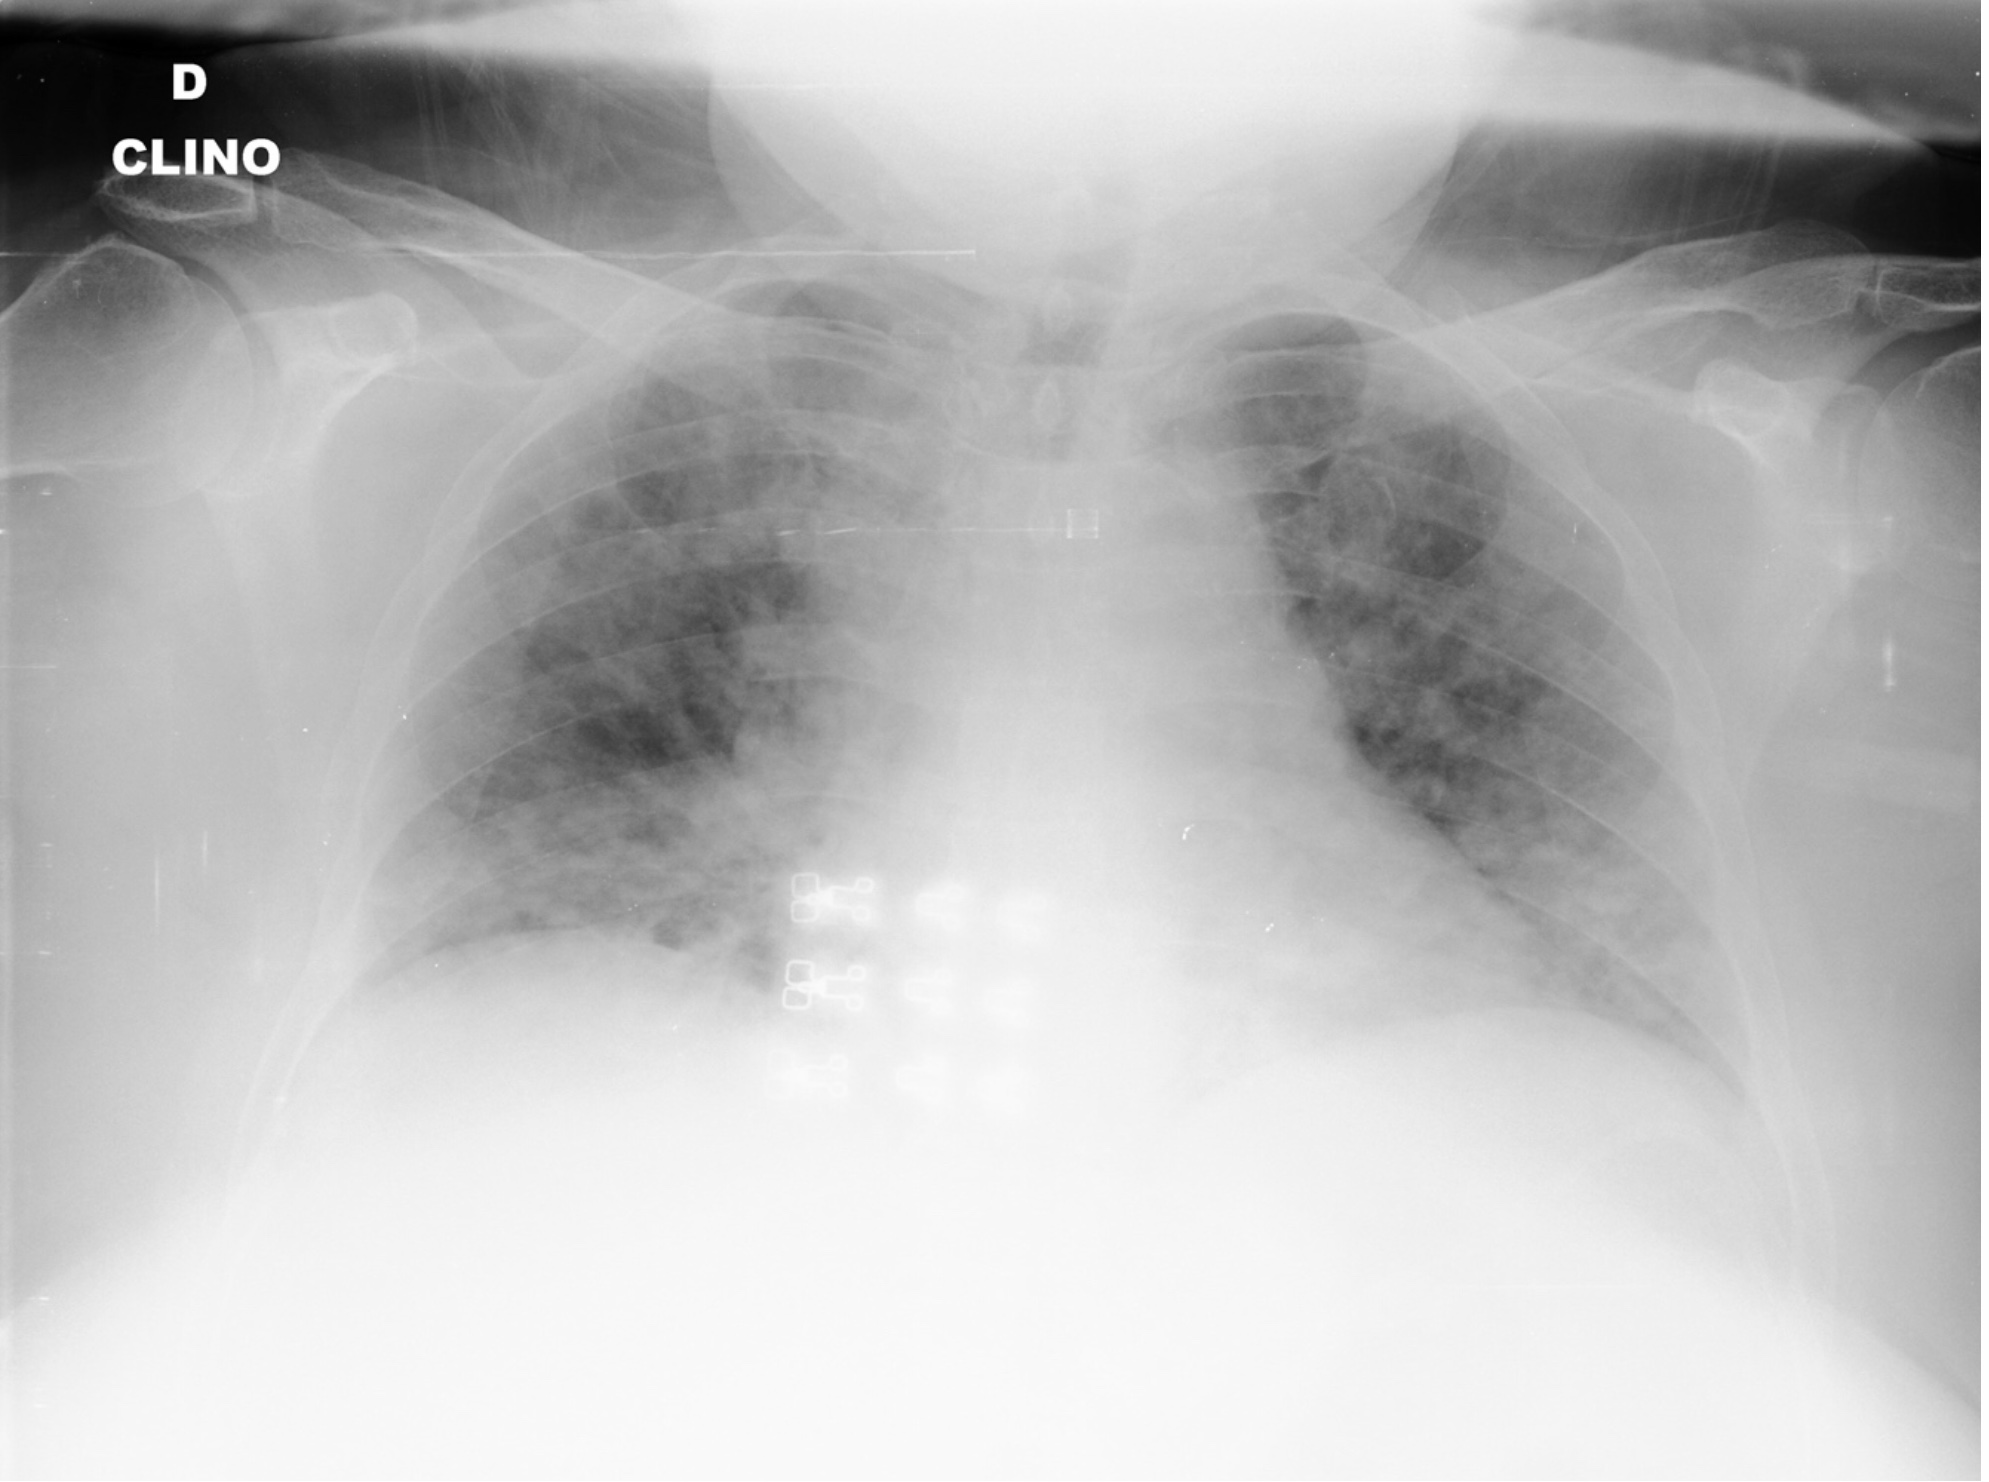

In [2]:
from PIL import Image
img = Image.open("./archive/xray_dataset_covid19/train/NORMAL/IM-0001-0001.jpeg")
img1 = Image.open("./archive/xray_dataset_covid19/train/PNEUMONIA/01E392EE-69F9-4E33-BFCE-E5C968654078.jpeg")
img1

In [3]:
transform = T.Compose([
            T.ToTensor(),
            T.Normalize((0.5, ), (0.5, )),
            T.Resize((256, 256))
])
imtensor = transform(img1)
imtensor.size()

torch.Size([3, 256, 256])

In [4]:
resize = T.Resize((256, 256))
img_resize = resize(imtensor)
img_resize.size()

torch.Size([3, 256, 256])

In [5]:
#wrong_path_for_ImageFolder = '/root/archive/xray_dataset_covid19/train/NORMAL/'
'''
ImageFolder will assign a class index to each subfolder. 
Usually you would thus have subfolders in the train and test folders. 
If you pass the root folder of train and test to ImageFolder these two 
folders will have a target value of 0 and 1, respectively.
'''

train_path = './archive/xray_dataset_covid19/train/'
test_path = './archive/xray_dataset_covid19/test/'

In [6]:
from torchvision import datasets

#ds_n = datasets.ImageFolder(normal_path, transform=transform)
ds_train = datasets.ImageFolder(train_path, transform=transform)
ds_test = datasets.ImageFolder(test_path, transform=transform)
print('Train set: \n', ds_train,
     ' \nTest set: \n', ds_test)

Train set: 
 Dataset ImageFolder
    Number of datapoints: 148
    Root location: ./archive/xray_dataset_covid19/train/
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
               Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=None)
           )  
Test set: 
 Dataset ImageFolder
    Number of datapoints: 40
    Root location: ./archive/xray_dataset_covid19/test/
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
               Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=None)
           )


In [7]:
trainloader = torch.utils.data.DataLoader(ds_train, batch_size=32,
                                         shuffle=True, num_workers=4)
testloader = torch.utils.data.DataLoader(ds_test, batch_size=32,
                                         shuffle=False, num_workers=4)

In [8]:
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.cpu().numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

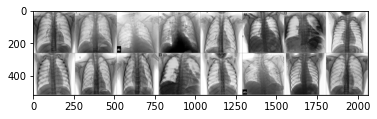

In [9]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
# create grid of images
img_grid = torchvision.utils.make_grid(images[:16])

# show images
matplotlib_imshow(img_grid, one_channel=True)

In [10]:
images[10].shape

torch.Size([3, 256, 256])

In [11]:
class Covid19(pl.LightningModule):
    def __init__(self, learning_rate=0.0005):
    
        super(Covid19, self).__init__()
        self.save_hyperparameters()
        self.hparams.learning_rate = learning_rate
    
    
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, padding=1) # [3, 512, 512] => [8, 510, 510]
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # =>[2, 255, 255]
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, padding=1) #[8, 256, 256] 
        self.pool2 = nn.MaxPool2d(2, 2) # [8, 128, 128]
        self.conv3 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1) #[16, 128, 128]
        self.conv4 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1)
        #self.pool3 = nn.MaxPool2d(2, 2) #[16, 63, 63]
        
        self.fc1 = nn.Linear(16 *64 * 64, 1000)
        self.fc2 = nn.Linear(1000, 500)
        self.fc3 = nn.Linear(500, 10)
        self.fc4 = nn.Linear(10, 2)
    
    
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.pool1(x))
        x = self.conv2(x)
        x = F.relu(self.pool2(x))
        x = self.conv3(x)
        x = self.conv4(x)
        #x = F.relu(self.pool3(x))
        
        x = x.view(x.shape[0], 16 * 64 * 64)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.softmax(self.fc4(x))
        
        return x
    
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x) # model training <=> model(x)
        #identifying number of correct predictions in a given batch
        correct = logits.argmax(dim=1).eq(y).sum().item() # summing array of zeros and ones. number of ones give us number of correct items
        # Number of Ones gives the correct number of our model prediction
        
        #total number of lables
        total = len(y)
        
        train_loss = F.cross_entropy(logits, y)
        
        logs = {'train_loss':train_loss}
        
        batch_dictionary = {
            #REQUIRED: It is required for us to return loss
            "loss": train_loss,
            
            #OPTIONAL: for batch logging purpose
            'logs': logs,
            
            #info to be used as epoch end
            "correct": correct,
            "total": total
        }
        
        return batch_dictionary
    
    def custom_histogram_adder(self):
        # iterating through all parameters
        for name, params in self.named_parameters():
            self.logger.experiment.add_histogram(name, params, self.current_epoch)
                

    def training_epoch_end(self, outputs):
        #  the function is called after every epoch is completed
        # output: a list of dictionaries has been returned from thraning_step
        # calculating average loss
        avg_loss = torch.stack([x['loss'] for x in outputs]).mean()
        
        #  calculating correct and total predictions
        correct = sum([x['correct'] for x in outputs])
        total = sum([x['total'] for x in outputs])
        
        # save graph at the last epoch
        if(self.current_epoch==10
          ):
            sampleImg=torch.rand((1,1,28,28))
            self.logger.experiment.add_graph(eval(type(self).__name__)(), sampleImg)


        self.custom_histogram_adder()

        # logging using tensorboard logger
        self.logger.experiment.add_scalar("Loss/Train",
                                            avg_loss,
                                            self.current_epoch)

        self.logger.experiment.add_scalar("Accuracy/Train",
                                            correct/total,
                                            self.current_epoch)
        
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = accuracy(preds, y)
        
        # Calling self.log will surface up scalars for you in TensorBoard
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)
        return loss
    
    def test_step(self, batch, batch_idx):
        #  Here we just reuse the validation_step for testing
        return self.validation_step(batch, batch_idx)
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.learning_rate)
        
        return optimizer

### If you prefer using Regularization layers, e.g., BN, do not execute following 4 cells !!!

In [12]:
covid_model = Covid19()

In [13]:
AVAIL_GPU = min(1, torch.cuda.device_count())
print(f'Available GPU: {AVAIL_GPU} device(s)')

Available GPU: 1 device(s)


In [14]:
from pytorch_lightning.loggers import TensorBoardLogger
logger = TensorBoardLogger('/home/mohammadreza/Desktop/pyprojs/logger/', 'Covid')

trainer = pl.Trainer(gpus=AVAIL_GPU, max_epochs=10, logger=logger)
trainer.fit(covid_model, trainloader)

/home/mohammadreza/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/mohammadreza/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:117: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type      | Params
------------------------------------
0 | conv1 | Conv2d    | 224   
1 | pool1 | MaxPool2d | 0     
2 | conv2 | Conv2d    | 584   
3 | pool2 | MaxPool2d | 0     
4 | conv3 | Conv2d    | 1.2 K 
5 | conv4 | Conv2d    | 2.3 K 
6 | f

Epoch 0:  20%|███████████▏                                            | 1/5 [00:05<00:21,  5.43s/it]

/tmp/ipykernel_14319/1081299847.py:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.fc4(x))


Epoch 9: 100%|██████████████████████████████████| 5/5 [00:11<00:00,  2.23s/it, loss=0.353, v_num=29]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████████████████████████████| 5/5 [00:13<00:00,  2.74s/it, loss=0.353, v_num=29]


In [15]:
trainer.test(covid_model, testloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 19.04it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.9750000238418579
        val_loss            0.3506298065185547
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


/tmp/ipykernel_14319/1081299847.py:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.fc4(x))


[{'val_loss': 0.3506298065185547, 'val_acc': 0.9750000238418579}]

In [16]:
#device = torch.device(f'cuda:{np.random.randint(1)}')
#device = torch.device('cpu')
#covid_model = Covid19().to(device)

In [17]:
# Regularization Layers method
'''

import tqdm

def train_model(model, epochs, learning_rate):
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    train_loss = []
    test_loss = []
    test_accuracy = []
    
    for epoch in range(epochs):
        model.train()
        
        for i, (x,y) in enumerate(tqdm.tqdm(trainloader)):
            x, y = x.to(device), y.to(device)
            
            pred = model(x)
            loss = loss_fn(pred, y)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            
            train_loss.append(loss.item())
        
        model.eval()
        epoch_losses = []
        epoch_accuracy = []
        
        with torch.no_grad():
            for X, y in testloader:
                X, y = X.to(device), y.to(device)
                
                pred = model(X)
                epoch_losses.append(loss_fn(pred, y).item())
                _, pred = torch.max(pred.data, 1)
                epoch_accuracy.append(
                    (pred == y).to(torch.float32).mean().item()
                                     )
                test_loss.append(epoch_losses)
                test_accuracy.append(epoch_accuracy)
    return dict(
            train_loss=train_loss,
            test_loss=test_loss,
            test_accuracy=test_accuracy
    )        
    
'''

'\n\nimport tqdm\n\ndef train_model(model, epochs, learning_rate):\n    loss_fn = nn.CrossEntropyLoss()\n    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)\n    \n    train_loss = []\n    test_loss = []\n    test_accuracy = []\n    \n    for epoch in range(epochs):\n        model.train()\n        \n        for i, (x,y) in enumerate(tqdm.tqdm(trainloader)):\n            x, y = x.to(device), y.to(device)\n            \n            pred = model(x)\n            loss = loss_fn(pred, y)\n            loss.backward()\n            optimizer.step()\n            optimizer.zero_grad()\n            \n            \n            train_loss.append(loss.item())\n        \n        model.eval()\n        epoch_losses = []\n        epoch_accuracy = []\n        \n        with torch.no_grad():\n            for X, y in testloader:\n                X, y = X.to(device), y.to(device)\n                \n                pred = model(X)\n                epoch_losses.append(loss_fn(pred, y).item()

In [18]:
#train_model(model=covid_model, epochs=3, learning_rate=0.0005)